# Car Price Prediction

In [839]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [840]:
df = pd.read_csv("./car_price_dataset.csv")
# Note - Mileage => How many km has the car travelled

In [841]:
df.isnull().sum().sum()

0

In [842]:
df.head(5)

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [843]:
# All data types are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


In [844]:
# df["Year"] = df["Year"].values
# df["Year"] = df["Year"].to_numpy() - 2000

In [845]:
df["Year"]

0       2020
1       2012
2       2020
3       2023
4       2003
        ... 
9995    2004
9996    2002
9997    2010
9998    2002
9999    2001
Name: Year, Length: 10000, dtype: int64

In [846]:
y = df["Price"]
X = df.drop(["Price"], axis=1)

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4)
print("Training data", X_train.shape, y_train.shape)

X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5)
print("Cross Validation: ", X_cv.shape, y_cv.shape, "\nTest Data: ", X_test.shape, y_test.shape)

Training data (6000, 9) (6000,)
Cross Validation:  (2000, 9) (2000,) 
Test Data:  (2000, 9) (2000,)


In [847]:
label_encoding_cols = ["Model", "Fuel_Type", "Transmission", "Brand"] # Label encoding for XGBoost

In [848]:
encoders: dict[str, 'LabelEncoder'] = {}

for item in label_encoding_cols:
    encoder = LabelEncoder()
    series = X_train[item]
    encoder.fit(series)

    X_train[item] = encoder.transform(X_train[item])
    X_cv[item] = encoder.transform(X_cv[item])
    X_test[item] = encoder.transform(X_test[item])

    encoders[item] = encoder

X_train

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count
5027,0,2,2013,2.8,3,0,226670,4,5
4821,4,8,2000,3.8,2,2,198579,2,3
8020,6,26,2006,4.5,2,1,246638,4,2
416,9,27,2009,1.5,1,2,204370,4,4
7575,0,2,2019,3.8,1,0,37886,5,3
...,...,...,...,...,...,...,...,...,...
6199,6,20,2018,4.8,2,1,265363,2,2
2106,4,8,2003,3.3,0,0,150771,3,1
7802,0,22,2020,3.8,2,2,101820,4,3
5567,9,27,2017,1.2,3,1,255250,4,2


In [849]:
# for item in label_encoding_cols:
#     encoder = encoders[item]
#     X_train[item] = encoder.inverse_transform(X_train[item])

# X_train

In [850]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

In [851]:
scalar.fit(X_train["Mileage"].values.reshape(-1, 1))

X_train["Mileage"] = scalar.transform(X_train["Mileage"].values.reshape(-1, 1))
X_cv["Mileage"] = scalar.transform(X_cv["Mileage"].values.reshape(-1, 1))
X_test["Mileage"] = scalar.transform(X_test["Mileage"].values.reshape(-1, 1))

In [852]:
print(f"Min value: {X_train["Mileage"].min():0.2f}, Max Value: {X_train["Mileage"].max():0.2f}")
print(f"Mean: {X_train["Mileage"].mean():0.2f}")

Min value: -1.74, Max Value: 1.75
Mean: 0.00


In [853]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score

In [854]:
d_train = xgb.DMatrix(X_train, label=y_train) # Converting to DMatrix for faster calculation
d_cv = xgb.DMatrix(X_cv, label=y_cv) # Converting to DMatrix for faster calculation
d_test = xgb.DMatrix(X_test, label=y_test) # Converting to DMatrix for faster calculation

### Training

In [855]:
params = {
    "objective": "reg:squarederror",  # Regression objective
    "eval_metric": "rmse",
    "learning_rate": 0.06,
    "max_depth": 2,
    "alpha": 3,
    "lambda": 4
}

In [856]:
evals_result = {}

model = xgb.train(
    params=params, 
    dtrain=d_train, 
    num_boost_round=2500, 
    evals=[(d_train, "train"), (d_test, "test")], 
    evals_result=evals_result,  # ✅ Store loss values
    early_stopping_rounds=100,
)

[0]	train-rmse:3031.62242	test-rmse:2974.99652
[1]	train-rmse:2936.82867	test-rmse:2883.38772
[2]	train-rmse:2849.51333	test-rmse:2799.12838
[3]	train-rmse:2768.15813	test-rmse:2719.45388
[4]	train-rmse:2692.12390	test-rmse:2646.83531
[5]	train-rmse:2622.14205	test-rmse:2578.01184
[6]	train-rmse:2555.88964	test-rmse:2514.66889
[7]	train-rmse:2494.51322	test-rmse:2455.59164
[8]	train-rmse:2436.91931	test-rmse:2400.39395
[9]	train-rmse:2380.67967	test-rmse:2346.48406
[10]	train-rmse:2328.93374	test-rmse:2297.03311
[11]	train-rmse:2279.35214	test-rmse:2250.10586
[12]	train-rmse:2232.40641	test-rmse:2203.73987
[13]	train-rmse:2187.37329	test-rmse:2161.11371
[14]	train-rmse:2143.94889	test-rmse:2119.56672
[15]	train-rmse:2102.88719	test-rmse:2080.31295
[16]	train-rmse:2063.79235	test-rmse:2042.44427
[17]	train-rmse:2025.87463	test-rmse:2005.75281
[18]	train-rmse:1989.87805	test-rmse:1971.79235
[19]	train-rmse:1955.49231	test-rmse:1938.89221
[20]	train-rmse:1921.65825	test-rmse:1906.67244
[2

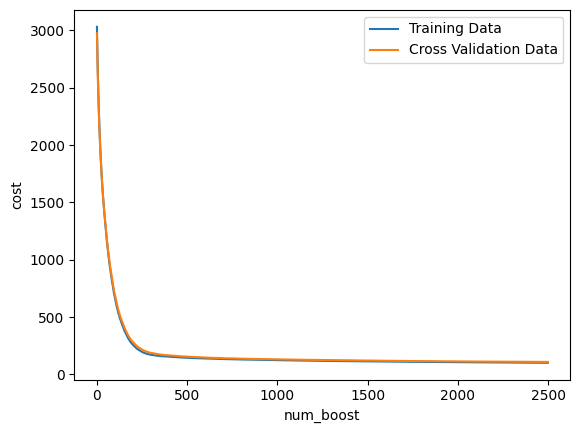

In [861]:
plt.plot(evals_result["train"]["rmse"])
plt.plot(evals_result["test"]["rmse"])
plt.legend(["Training Data", "Cross Validation Data"])
plt.xlabel("num_boost")
plt.ylabel("cost")
plt.show()

In [862]:
pred = model.predict(d_test)
print(mean_squared_error(y_test, pred))

11974.638671875


In [900]:
model.get_score(importance_type="weight")

{'Brand': 65.0,
 'Model': 77.0,
 'Year': 2136.0,
 'Engine_Size': 1576.0,
 'Fuel_Type': 645.0,
 'Transmission': 221.0,
 'Mileage': 2677.0,
 'Doors': 46.0,
 'Owner_Count': 57.0}

In [888]:
diff = list(zip(y_test, pred))

In [891]:
# y_train[lambda x: x < 5000]

4821    4928
5614    3109
5141    3470
1991    4460
6384    4522
        ... 
652     3519
7052    3837
8575    3786
9493    3463
4292    4805
Name: Price, Length: 732, dtype: int64

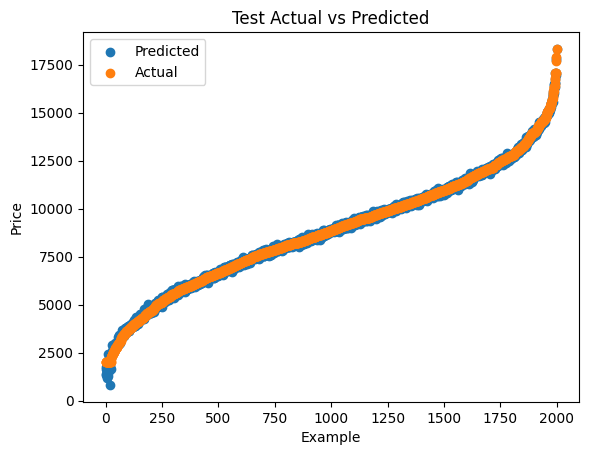

79.29533560180664

In [901]:
plot = np.array(list(sorted(diff, key=lambda x: x[0])))

plt.scatter(np.arange(y_test.shape[0]), plot[:, 1])
plt.scatter(np.arange(y_test.shape[0]), plot[:, 0])
plt.xlabel("Example")
plt.ylabel("Price")
plt.legend(["Predicted", "Actual"])
plt.title("Test Actual vs Predicted")
plt.show()

MAE = np.mean(np.abs(y_test - pred))
MAE

### K-FOLD Analysis

In [902]:
from sklearn.model_selection import KFold
import xgboost as xgb
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
mae_scores = []

for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=100,
        verbose_eval=False
    )

    preds = model.predict(dval)
    rmse = np.sqrt(np.mean((preds - y_val) ** 2))
    mae = np.mean(np.abs(preds - y_val))

    rmse_scores.append(rmse)
    mae_scores.append(mae)

print(f"Avg RMSE: {np.mean(rmse_scores):.4f}")
print(f"Avg MAE: {np.mean(mae_scores):.4f}")


Avg RMSE: 124.9490
Avg MAE: 85.5493


In [907]:
import pickle as pkl

for item in label_encoding_cols:
    with open(f"{item}.pkl", "wb") as file:
        pkl.dump(encoders[item], file)

In [908]:
with open("Mileage_Scalar.pkl", "wb") as file:
    pkl.dump(scalar, file)

In [909]:
with open("XGBModel.pkl", "wb") as file:
    pkl.dump(model, file)